## Preprocessing 

In [355]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
'''
Welcome to Optiver 2023 MoC Challenge! We designed this notebook for you to explore the data given by the challenge, research and design your own factors based on
the training data given and the helper functions we built for you!
Feel free to play around with the data and get familiar with it!
'''

# We will import the necessary libraries here. You can import any librariese you need for your beautiful factors!
from factor_design_ver2_beta import utils
from factor_design_ver2_beta import factor_design
from factor_design_ver2_beta import factor_backtest
# from joblib import Parallel, delayed # waited to be optimized
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats
import queue

In [357]:
# DON'T RE-RUN THIS CELL TOO OFTEN! The loading time for training data is a bit long.
# Please make sure you have been provided with the training data with such name in the same folder as this notebook.
# You can play around with this file for your own research and factor design.
df_train = pd.read_csv('./research_train_set.csv')

# We built a index map to speed up the factor design, you don't need to worry about this.
col2index_map = utils.load_json('./factor_design_ver2_beta/col2index_map.json')

## Factor Design

In [358]:
# We designed a function to transform the df_train you loaded into a dictionary to speed up the research process.
# You don't need to worry about this. This will take up to half minutes to run. DON'T RE-RUN THIS CELL TOO OFTEN!
df_train_dic_sorted = utils.load_json('./factor_design_ver2_beta/df_train_dic_sorted.json')

In [359]:
'''
In this part you will design your own factors! We have provided you with some helper functions to speed up the process.
We look forward to receving your beautiful factors!
'''
# Before you start, we provide you with a sample factor design here.
# Please STRICTLY FOLLOW the instructions below to design your own factors!
'''
1. You can design your own factors based on the training data given. However, you CANNOT use the target variable (i.e. 'target') in your factor design!!
2. You can use any public libraries you want to design your factors.
3. The factor design should be the following format:
def your_factor_name(current_data: dict, hist_list: list) -> np.ndarray:
    The overall training data given by Kaggle competition is a dataset that contains relevant stocks' features of last 9 minutes (540 seconds) of multiple
    trading days. The data is in the form that, in the order of each trading day, we will have all available stocks' features for 55 time buckets, 10 seconds long
    for each bucket. For example, the first 10 seconds of the first trading day, we will have all available stocks' features, then the second 10 seconds, and so on.
    
    We are predicting the target variable (i.e. 'target') for each 10 seconds bucket on each day (time snapshot).
    
    When we submit our prediction, the test data will come in with same features of all available stocks at a time snapshot, and we predict only based on all the
    time snapshots given we have. The current_data in the sample function will be the data in the current time snapshot, for example, the data from 0s to 10s of the
    first trading day for all stocks. The hist_list is set to be empty list as default, and THIS IS DESIGNED for you in case you want to STORE any previous data for
    your factor design. For example, you can create a time-series factor that uses the data from previous time snapshots, and you can store the previous data in the
    hist_list.


    The return will be the factor value you calculated. The format HAS TO BE np.ndarray, and the shape of the return HAS TO BE (n_stocks, )
'''

"\n1. You can design your own factors based on the training data given. However, you CANNOT use the target variable (i.e. 'target') in your factor design!!\n2. You can use any public libraries you want to design your factors.\n3. The factor design should be the following format:\ndef your_factor_name(current_data: dict, hist_list: list) -> np.ndarray:\n    The overall training data given by Kaggle competition is a dataset that contains relevant stocks' features of last 9 minutes (540 seconds) of multiple\n    trading days. The data is in the form that, in the order of each trading day, we will have all available stocks' features for 55 time buckets, 10 seconds long\n    for each bucket. For example, the first 10 seconds of the first trading day, we will have all available stocks' features, then the second 10 seconds, and so on.\n    \n    We are predicting the target variable (i.e. 'target') for each 10 seconds bucket on each day (time snapshot).\n    \n    When we submit our predictio

### Mid Price

In [360]:
def mid_price(current_data: dict, hist_list=[]) -> np.ndarray:
    '''
    This will be the main function to design your factors for the competition. Please
    define only one factor here each time. We provide you with:

    Current_data: a dictionary in the format of {column_name: column_value}, where column_name is from the original
    dataframe

    hist_list: A list for you to save the previous factor values (optional). For instance,
    if you are calculating a 100-day Moving Average (MA), then you can save the first calculated
    MA in hist_list, and then for the next MA calculation, you can use the saved ones.
    '''
    ###################### ADD YOUR CODE HERE FOR FACTORS DESIGN ######################
    # convert the current_data to your choice of numpy or pandas dataframe
    # current_data = pd.DataFrame(current_data)
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    res = (current_data[:, col2index_map['ask_price']] + current_data[:, col2index_map['bid_price']]) / 2
    ############################## NAN/Inf handling ######################################
    # if you have nan in your factor value, please fill it reasonably
    # res = np.nan_to_num(res) # this is slow because it also checks for inf.
    # res = np.where(np.isnan(res), 0, res)  # this is slightly faster than np.nan_to_num
    res[np.isnan(res)] = 0  # this is the fastest way to fill nan with 0
    ############################## END OF YOUR CODE ##############################
    return res  # The return value MUSE BE a numpy array, with no NaN value
    ####################################################################################


In [361]:
def mid_price_std5(current_data: dict, hist_list=[]) -> np.ndarray:
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    current_time = current_data[0, col2index_map['seconds_in_bucket']]
    current_spread = (current_data[:, col2index_map['ask_price']] + current_data[:, col2index_map['bid_price']]) / 2
    if current_time == 0:
        if len(hist_list) == 0:
            # we are at the very beginning of the data set
            hist_list.append(queue.Queue())
        else:
            # new day, we clear the queue
            hist_list[0].queue.clear()
    if current_time < 50:
        hist_list[0].put(current_spread)
        res = np.zeros(current_spread.shape)
    else:
        hist_list[0].put(current_spread)
        # calculate the past 60s return
        res = np.std(list(hist_list[0].queue), axis=0)
        # pop the oldest data
        hist_list[0].get()
    res[np.isnan(res)] = 0  # this is the fastest way to fill nan with 0
    return res

### S1 Imbalance

In [362]:
def s1_imbalance(current_data: dict, hist_list=[]) -> np.ndarray:
    '''
    This will be the main function to design your factors for the competition. Please
    define only one factor here each time. We provide you with:

    Current_data: a dictionary in the format of {column_name: column_value}, where column_name is from the original
    dataframe

    hist_list: A list for you to save the previous factor values (optional). For instance,
    if you are calculating a 100-day Moving Average (MA), then you can save the first calculated
    MA in hist_list, and then for the next MA calculation, you can use the saved ones.
    '''
    ###################### ADD YOUR CODE HERE FOR FACTORS DESIGN ######################
    # convert the current_data to your choice of numpy or pandas dataframe
    # current_data = pd.DataFrame(current_data)
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    res = (current_data[:, col2index_map['bid_size']] - current_data[:, col2index_map['ask_size']]) / \
          (current_data[:, col2index_map['bid_size']] + current_data[:, col2index_map['ask_size']])
    ############################## NAN/Inf handling ######################################
    # if you have nan in your factor value, please fill it reasonably
    # res = np.nan_to_num(res) # this is slow because it also checks for inf.
    # res = np.where(np.isnan(res), 0, res)  # this is slightly faster than np.nan_to_num
    res[np.isnan(res)] = 0  # this is the fastest way to fill nan
    ############################## END OF YOUR CODE ##############################
    return -res  # The return value MUSE BE a numpy array, with no NaN value
    ####################################################################################


In [363]:
def s1_imbalance_rank(current_data: dict, hist_list=[]) -> np.ndarray:
    '''
    This will be the main function to design your factors for the competition. Please
    define only one factor here each time. We provide you with:

    Current_data: a dictionary in the format of {column_name: column_value}, where column_name is from the original
    dataframe

    hist_list: A list for you to save the previous factor values (optional). For instance,
    if you are calculating a 100-day Moving Average (MA), then you can save the first calculated
    MA in hist_list, and then for the next MA calculation, you can use the saved ones.
    '''
    ###################### ADD YOUR CODE HERE FOR FACTORS DESIGN ######################
    # convert the current_data to your choice of numpy or pandas dataframe
    # current_data = pd.DataFrame(current_data)
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    res = (current_data[:, col2index_map['bid_size']] - current_data[:, col2index_map['ask_size']]) / \
          (current_data[:, col2index_map['bid_size']] + current_data[:, col2index_map['ask_size']])
    ############################## NAN/Inf handling ######################################
    # if you have nan in your factor value, please fill it reasonably
    # res = np.nan_to_num(res) # this is slow because it also checks for inf.
    # res = np.where(np.isnan(res), 0, res)  # this is slightly faster than np.nan_to_num
    res[np.isnan(res)] = 0  # this is the fastest way to fill nan
    res = stats.rankdata(-res) / len(res)
    ############################## END OF YOUR CODE ##############################
    return res  # The return value MUSE BE a numpy array, with no NaN value
    ####################################################################################


In [364]:
def s1_imbalance_signed_pow_opt(current_data: dict, hist_list=[]) -> np.ndarray:
    '''
    This will be the main function to design your factors for the competition. Please
    define only one factor here each time. We provide you with:

    Current_data: a dictionary in the format of {column_name: column_value}, where column_name is from the original
    dataframe

    hist_list: A list for you to save the previous factor values (optional). For instance,
    if you are calculating a 100-day Moving Average (MA), then you can save the first calculated
    MA in hist_list, and then for the next MA calculation, you can use the saved ones.
    '''
    ###################### ADD YOUR CODE HERE FOR FACTORS DESIGN ######################
    # convert the current_data to your choice of numpy or pandas dataframe
    # current_data = pd.DataFrame(current_data)
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    res = (current_data[:, col2index_map['bid_size']] - current_data[:, col2index_map['ask_size']]) / \
          (current_data[:, col2index_map['bid_size']] + current_data[:, col2index_map['ask_size']])
    ############################## NAN/Inf handling ######################################
    # if you have nan in your factor value, please fill it reasonably
    # res = np.nan_to_num(res) # this is slow because it also checks for inf.
    # res = np.where(np.isnan(res), 0, res)  # this is slightly faster than np.nan_to_num
    res[np.isnan(res)] = 0  # this is the fastest way to fill nan
    ############################## END OF YOUR CODE ##############################
    return np.sign(-res) * np.abs(
        res) ** 1.4242424242424243  # The return value MUSE BE a numpy array, with no NaN value
    # reason: s1_imbalance have most information in sign, sign can be think of as sign*abs**0. we optimize the power and get 1.424 as the best
    ####################################################################################


In [365]:
def s1_imbalance_rank_signed_pow_opt(current_data: dict, hist_list=[]) -> np.ndarray:
    '''
    This will be the main function to design your factors for the competition. Please
    define only one factor here each time. We provide you with:

    Current_data: a dictionary in the format of {column_name: column_value}, where column_name is from the original
    dataframe

    hist_list: A list for you to save the previous factor values (optional). For instance,
    if you are calculating a 100-day Moving Average (MA), then you can save the first calculated
    MA in hist_list, and then for the next MA calculation, you can use the saved ones.
    '''
    ###################### ADD YOUR CODE HERE FOR FACTORS DESIGN ######################
    # convert the current_data to your choice of numpy or pandas dataframe
    # current_data = pd.DataFrame(current_data)
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    res = (current_data[:, col2index_map['bid_size']] - current_data[:, col2index_map['ask_size']]) / \
          (current_data[:, col2index_map['bid_size']] + current_data[:, col2index_map['ask_size']])
    ############################## NAN/Inf handling ######################################
    # if you have nan in your factor value, please fill it reasonably
    # res = np.nan_to_num(res) # this is slow because it also checks for inf.
    # res = np.where(np.isnan(res), 0, res)  # this is slightly faster than np.nan_to_num
    res[np.isnan(res)] = 0  # this is the fastest way to fill nan
    res = stats.rankdata(-res) / len(res)
    res = (res - 0.5) * 2
    res = np.sign(res) * np.abs(res) ** 1.4848484848484849  # optimized in-sample
    ############################## END OF YOUR CODE ##############################
    return res  # The return value MUSE BE a numpy array, with no NaN value
    # reason: s1_imbalance have most information in sign, sign can be think of as sign*abs**0. we optimize the power and get 1.424 as the best
    ####################################################################################


### Stock return

In [366]:
def past_10s_ret(current_data: dict, hist_list=[]):
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    current_time = current_data[0, col2index_map['seconds_in_bucket']]
    current_wap = current_data[:, col2index_map['wap']]
    if current_time < 10:
        if len(hist_list) == 0:
            hist_list.append(
                queue.Queue())  # if we directly claim hist_list = [queue.Queue()], it will be a local variable
        else:
            hist_list[0].queue.clear()
        hist_list[0].put(current_wap)
        res = np.zeros(current_wap.shape)
    else:
        hist_list[0].put(current_wap)
        # calculate the past 60s return
        past_wap = hist_list[0].get()
        res = (current_wap - past_wap) / past_wap
    res[np.isnan(res)] = 0  # this is the easiest way to fill nan
    return -res

In [367]:
def past_10s_ret_exp_opt(current_data: dict, hist_list=[]):
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    current_time = current_data[0, col2index_map['seconds_in_bucket']]
    current_wap = current_data[:, col2index_map['wap']]
    if current_time < 10:
        if len(hist_list) == 0:
            hist_list.append(
                queue.Queue())  # if we directly claim hist_list = [queue.Queue()], it will be a local variable
        else:
            hist_list[0].queue.clear()
        hist_list[0].put(current_wap)
        res = np.zeros(current_wap.shape)
    else:
        hist_list[0].put(current_wap)
        # calculate the past 60s return
        past_wap = hist_list[0].get()
        res = (current_wap - past_wap) / past_wap
    res[np.isnan(res)] = 0  # this is the easiest way to fill nan
    return np.exp(-res * 57)

In [368]:
def past_30s_ret_rank(current_data: dict, hist_list=[]):
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    current_time = current_data[0, col2index_map['seconds_in_bucket']]
    current_wap = current_data[:, col2index_map['wap']]
    if current_time < 30:
        if current_time == 0:
            if len(hist_list) == 0:
                hist_list.append(queue.Queue())
            else:
                hist_list[0].queue.clear()
        hist_list[0].put(current_wap)
        res = np.zeros(current_wap.shape)
    else:
        hist_list[0].put(current_wap)
        # calculate the past 60s return
        past_wap = hist_list[0].get()
        res = (current_wap - past_wap) / past_wap
    res[np.isnan(res)] = 0  # this is the easiest way to fill nan
    return -stats.rankdata(res, method='min') / (len(res) + 1)

### Synthetic Index

In [369]:
def stock_20s_ret_deviate_from_index(current_data: dict, hist_list=[]):
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    current_time = current_data[0, col2index_map['seconds_in_bucket']]
    current_wap = current_data[:, col2index_map['wap']]
    if len(hist_list) == 0:
        hist_list.append([
            0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
            0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
            0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
            0.004, 0.004, 0.006, 0.002, 0.002, 0.04, 0.002, 0.002, 0.004, 0.04, 0.002, 0.001,
            0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
            0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
            0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
            0.02, 0.004, 0.006, 0.002, 0.02, 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
            0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
            0.004, 0.006, 0.006, 0.001, 0.04, 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
            0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
            0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
            0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
            0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
            0.04, 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02, 0.004, 0.002, 0.006, 0.02,
            0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
            0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
        ])
    if current_time < 20:
        if current_time == 0:
            if len(hist_list) == 1:
                hist_list.append(queue.Queue())
            else:
                hist_list[1].queue.clear()
        hist_list[1].put(current_wap)
        ret = np.zeros(current_wap.shape)
    else:
        hist_list[1].put(current_wap)
        # calculate the past 60s return
        past_wap = hist_list[1].get()
        ret = (current_wap - past_wap) / past_wap
    # for robustness, if the stock_id is larger than 200, we use the average weight
    weight = [hist_list[0][int(stock_id)] if stock_id <= 200 else np.mean(hist_list[0]) for stock_id in
              current_data[:, col2index_map['stock_id']]]
    synthetic_index = np.sum(np.array(weight, dtype=float) * ret)
    res = ret - synthetic_index
    # if result is nan, we assign res=0
    res[np.isnan(res)] = 0  # this is the easiest way to fill nan
    return -res

In [370]:
def stock_40s_ret_deviate_from_index_rank(current_data: dict, hist_list=[]):
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    current_time = current_data[0, col2index_map['seconds_in_bucket']]
    current_wap = current_data[:, col2index_map['wap']]
    if len(hist_list) == 0:
        hist_list.append([
            0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
            0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
            0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
            0.004, 0.004, 0.006, 0.002, 0.002, 0.04, 0.002, 0.002, 0.004, 0.04, 0.002, 0.001,
            0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
            0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
            0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
            0.02, 0.004, 0.006, 0.002, 0.02, 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
            0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
            0.004, 0.006, 0.006, 0.001, 0.04, 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
            0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
            0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
            0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
            0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
            0.04, 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02, 0.004, 0.002, 0.006, 0.02,
            0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
            0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
        ])
    if current_time < 40:
        if current_time == 0:
            if len(hist_list) == 1:
                hist_list.append(queue.Queue())
            else:
                hist_list[1].queue.clear()
        hist_list[1].put(current_wap)
        ret = np.zeros(current_wap.shape)
    else:
        hist_list[1].put(current_wap)
        # calculate the past 60s return
        past_wap = hist_list[1].get()
        ret = (current_wap - past_wap) / past_wap
    # for robustness, if the stock_id is larger than 200, we use the average weight
    weight = [hist_list[0][int(stock_id)] if stock_id <= 200 else np.mean(hist_list[0]) for stock_id in
              current_data[:, col2index_map['stock_id']]]
    synthetic_index = np.sum(np.array(weight, dtype=float) * ret)
    res = ret - synthetic_index
    # if result is nan, we assign res=0
    res[np.isnan(res)] = 0  # this is the easiest way to fill nan
    return stats.rankdata(-res) / len(res)

In [371]:
def stock_40s_ret_deviate_from_index_rank_hedged_opt(current_data: dict, hist_list=[]):
    current_data = np.array(list(current_data.values()),
                            dtype=float).T  # this is faster than pd.DataFrame(current_data).values
    current_time = current_data[0, col2index_map['seconds_in_bucket']]
    current_wap = current_data[:, col2index_map['wap']]
    if len(hist_list) == 0:
        hist_list.append([
            0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
            0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
            0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
            0.004, 0.004, 0.006, 0.002, 0.002, 0.04, 0.002, 0.002, 0.004, 0.04, 0.002, 0.001,
            0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
            0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
            0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
            0.02, 0.004, 0.006, 0.002, 0.02, 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
            0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
            0.004, 0.006, 0.006, 0.001, 0.04, 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
            0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
            0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
            0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
            0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
            0.04, 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02, 0.004, 0.002, 0.006, 0.02,
            0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
            0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
        ])
    if current_time == 0:
        if len(hist_list) == 1:
            # then we are at the very start, initialize the hist_list with two queues, one for 40s ret one for 20s ret
            hist_list.append(queue.Queue())  # for the 40s ret
            hist_list.append(queue.Queue())  # for the 20s ret
        else:
            # its a new day, we clear the queue
            hist_list[1].queue.clear()
            hist_list[2].queue.clear()
    if current_time < 20:
        hist_list[2].put(current_wap)
        hedge_20s_ret = np.zeros(current_wap.shape)
    else:
        hist_list[2].put(current_wap)
        # calculate the past 60s return
        past_wap = hist_list[2].get()
        hedge_20s_ret = (current_wap - past_wap) / past_wap
    if current_time < 40:
        hist_list[1].put(current_wap)
        ret = np.zeros(current_wap.shape)
    else:
        hist_list[1].put(current_wap)
        # calculate the past 60s return
        past_wap = hist_list[1].get()
        ret = (current_wap - past_wap) / past_wap
    # for robustness, if the stock_id is larger than 200, we use the average weight
    weight = [hist_list[0][int(stock_id)] if stock_id <= 200 else np.mean(hist_list[0]) for stock_id in
              current_data[:, col2index_map['stock_id']]]
    synthetic_index = np.sum(np.array(weight, dtype=float) * ret)
    res = ret - synthetic_index
    hedge_20s_ret = (hedge_20s_ret - np.sum(np.array(weight, dtype=float) * hedge_20s_ret))
    # if result is nan, we assign res=0
    res[np.isnan(res)] = 0  # this is the easiest way to fill nan
    res = stats.rankdata(-res) / len(res)
    res = (res - 0.5) * 2
    res = utils.ols_res(hedge_20s_ret, res, 0.33)
    res[np.isnan(res)] = 0  # this is the easiest way to fill nan

    return res

# Some Examples of Factor Design

In [372]:
'''
Each factor should be defined as a function described above. After you designed all your factors and you are all good to test your factors,
you can simply ADD your factor name to the factor_list below, and run the cell. The backtest result will be printed out for you to see!
'''
# toned factor
new_factor_list = ['s1_imbalance_signed_pow_opt',
                   'past_10s_ret',
                   'past_30s_ret_rank',
                   "stock_20s_ret_deviate_from_index",
                   'stock_40s_ret_deviate_from_index_rank_hedged_opt']  # fine toned factor set

print(len(new_factor_list))
new_factor_list += ['stock_40s_ret_deviate_from_index_rank',
                    's1_imbalance_rank_signed_pow_opt',
                    "s1_imbalance",
                    "s1_imbalance_rank",
                    
                    ]  # in order to run the following code, we need to add these factor


# new_factor_list = ['mid_price','mid_price_std5']  # mid_price set
# new_factor_list = ['s1_imbalance', 's1_imbalance_signed_pow_opt',
# 's1_imbalance_rank_signed_pow_opt']  # s1 imbalance set

# return style factor
# new_factor_list = ['past_10s_ret','past_20s_ret','past_30s_ret','past_40s_ret','past_50s_ret','past_60s_ret','past_70s_ret','past_80s_ret','past_90s_ret','past_10s_ret_rank','past_20s_ret_rank','past_30s_ret_rank','past_40s_ret_rank','past_50s_ret_rank','past_60s_ret_rank','past_70s_ret_rank','past_80s_ret_rank','past_90s_ret_rank']# search for optimizing
# new_factor_list = ['past_10s_ret','past_10s_ret_exp_opt','past_30s_ret_rank']# selected optimized factors

# synthetic index
# new_factor_list = ['stock_10s_ret_deviate_from_index','stock_20s_ret_deviate_from_index','stock_30s_ret_deviate_from_index','stock_40s_ret_deviate_from_index','stock_50s_ret_deviate_from_index','stock_60s_ret_deviate_from_index','stock_70s_ret_deviate_from_index',"stock_80s_ret_deviate_from_index",'stock_90s_ret_deviate_from_index']  # search for optimizing the second
# new_factor_list = new_factor_list+[i+'_rank' for i in new_factor_list]# add rank

# new_factor_list = ['stock_20s_ret_deviate_from_index','stock_40s_ret_deviate_from_index_rank','stock_40s_ret_deviate_from_index_rank_hedged_opt']

5


In [373]:
# DO NOT MODIFY THE FOLLOWING CODE
# Run this cell once you want to calculate your factor values and prepare for the test of your factor performance!
new_factors = {factor_name: utils.flatten_factor_value(
    factor_design.run_factor_value(df_train_dic_sorted, eval(factor_name), factor_name), factor_name)[factor_name] for
               factor_name in tqdm(new_factor_list)}


  0%|          | 0/9 [00:00<?, ?it/s]

Start calculating factor s1_imbalance_signed_pow_opt
Finished calculating factor s1_imbalance_signed_pow_opt for 0 dates


C:\Users\kevin\AppData\Local\Temp\ipykernel_26120\827042783.py:18: RuntimeWarning:

invalid value encountered in divide



Finished calculating factor s1_imbalance_signed_pow_opt for 100 dates
Finished calculating factor s1_imbalance_signed_pow_opt for 200 dates
Finished calculating factor s1_imbalance_signed_pow_opt for 300 dates
Finished calculating factor s1_imbalance_signed_pow_opt for 400 dates
Accepted!!: Used 3.56 seconds for calculation factors. The limit is 300 seconds.



 11%|█         | 1/9 [00:04<00:32,  4.05s/it]

Start calculating factor past_10s_ret
Finished calculating factor past_10s_ret for 0 dates
Finished calculating factor past_10s_ret for 100 dates
Finished calculating factor past_10s_ret for 200 dates
Finished calculating factor past_10s_ret for 300 dates
Finished calculating factor past_10s_ret for 400 dates
Accepted!!: Used 3.47 seconds for calculation factors. The limit is 300 seconds.



 22%|██▏       | 2/9 [00:07<00:27,  3.99s/it]

Start calculating factor past_30s_ret_rank
Finished calculating factor past_30s_ret_rank for 0 dates
Finished calculating factor past_30s_ret_rank for 100 dates
Finished calculating factor past_30s_ret_rank for 200 dates
Finished calculating factor past_30s_ret_rank for 300 dates
Finished calculating factor past_30s_ret_rank for 400 dates
Accepted!!: Used 5.33 seconds for calculation factors. The limit is 300 seconds.



 33%|███▎      | 3/9 [00:13<00:28,  4.82s/it]

Start calculating factor stock_20s_ret_deviate_from_index
Finished calculating factor stock_20s_ret_deviate_from_index for 0 dates
Finished calculating factor stock_20s_ret_deviate_from_index for 100 dates
Finished calculating factor stock_20s_ret_deviate_from_index for 200 dates
Finished calculating factor stock_20s_ret_deviate_from_index for 300 dates
Finished calculating factor stock_20s_ret_deviate_from_index for 400 dates
Accepted!!: Used 4.97 seconds for calculation factors. The limit is 300 seconds.



 44%|████▍     | 4/9 [00:19<00:25,  5.08s/it]D:\Road2KaggleLord\Optiver_MOC\Optiver_MOC_Factor_Research_FrameworkV1\Optiver_MOC_Factor_Research_Framework\factor_design_ver2_beta\utils.py:129: RuntimeWarning:

invalid value encountered in scalar divide



Start calculating factor stock_40s_ret_deviate_from_index_rank_hedged_opt
Finished calculating factor stock_40s_ret_deviate_from_index_rank_hedged_opt for 0 dates
Finished calculating factor stock_40s_ret_deviate_from_index_rank_hedged_opt for 100 dates
Finished calculating factor stock_40s_ret_deviate_from_index_rank_hedged_opt for 200 dates
Finished calculating factor stock_40s_ret_deviate_from_index_rank_hedged_opt for 300 dates
Finished calculating factor stock_40s_ret_deviate_from_index_rank_hedged_opt for 400 dates
Accepted!!: Used 7.63 seconds for calculation factors. The limit is 300 seconds.



 56%|█████▌    | 5/9 [00:27<00:24,  6.17s/it]

Start calculating factor stock_40s_ret_deviate_from_index_rank
Finished calculating factor stock_40s_ret_deviate_from_index_rank for 0 dates
Finished calculating factor stock_40s_ret_deviate_from_index_rank for 100 dates
Finished calculating factor stock_40s_ret_deviate_from_index_rank for 200 dates
Finished calculating factor stock_40s_ret_deviate_from_index_rank for 300 dates
Finished calculating factor stock_40s_ret_deviate_from_index_rank for 400 dates
Accepted!!: Used 6.82 seconds for calculation factors. The limit is 300 seconds.



 67%|██████▋   | 6/9 [00:34<00:19,  6.55s/it]

Start calculating factor s1_imbalance_rank_signed_pow_opt
Finished calculating factor s1_imbalance_rank_signed_pow_opt for 0 dates
Finished calculating factor s1_imbalance_rank_signed_pow_opt for 100 dates
Finished calculating factor s1_imbalance_rank_signed_pow_opt for 200 dates
Finished calculating factor s1_imbalance_rank_signed_pow_opt for 300 dates
Finished calculating factor s1_imbalance_rank_signed_pow_opt for 400 dates
Accepted!!: Used 5.65 seconds for calculation factors. The limit is 300 seconds.



 78%|███████▊  | 7/9 [00:40<00:12,  6.42s/it]

Start calculating factor s1_imbalance
Finished calculating factor s1_imbalance for 0 dates
Finished calculating factor s1_imbalance for 100 dates
Finished calculating factor s1_imbalance for 200 dates
Finished calculating factor s1_imbalance for 300 dates
Finished calculating factor s1_imbalance for 400 dates
Accepted!!: Used 3.29 seconds for calculation factors. The limit is 300 seconds.



 89%|████████▉ | 8/9 [00:44<00:05,  5.58s/it]

Start calculating factor s1_imbalance_rank
Finished calculating factor s1_imbalance_rank for 0 dates
Finished calculating factor s1_imbalance_rank for 100 dates
Finished calculating factor s1_imbalance_rank for 200 dates
Finished calculating factor s1_imbalance_rank for 300 dates
Finished calculating factor s1_imbalance_rank for 400 dates
Accepted!!: Used 5.21 seconds for calculation factors. The limit is 300 seconds.



100%|██████████| 9/9 [00:50<00:00,  5.59s/it]


In [374]:
# check if all values in new_factor and original_factor_dict does not contain nan, no NA is allowed in the factor value
for factor_name, factor_value in new_factors.items():
    assert not np.isnan(factor_value).any(), f'{factor_name} contains nan'
    assert not np.isinf(factor_value).any(), f'{factor_name} contains inf'
    print(f'{factor_name} has correlation to target {np.corrcoef(factor_value, df_train["target"].fillna(0))[0, 1]}')


s1_imbalance_signed_pow_opt has correlation to target 0.11812815373942646
past_10s_ret has correlation to target 0.06664332162654614
past_30s_ret_rank has correlation to target 0.06302002013895729
stock_20s_ret_deviate_from_index has correlation to target 0.08267993902947415
stock_40s_ret_deviate_from_index_rank_hedged_opt has correlation to target 0.05405080675974954
stock_40s_ret_deviate_from_index_rank has correlation to target 0.06356041069195277
s1_imbalance_rank_signed_pow_opt has correlation to target 0.11727393510910067
s1_imbalance has correlation to target 0.11723116519487425
s1_imbalance_rank has correlation to target 0.11611365395799639


In [375]:
pd.DataFrame(new_factors).corr()

,s1_imbalance_signed_pow_opt,past_10s_ret,past_30s_ret_rank,stock_20s_ret_deviate_from_index,stock_40s_ret_deviate_from_index_rank_hedged_opt,stock_40s_ret_deviate_from_index_rank,s1_imbalance_rank_signed_pow_opt,s1_imbalance,s1_imbalance_rank
s1_imbalance_signed_pow_opt,1.000000,0.237049,0.218550,0.220271,0.190792,0.215557,0.988236,0.992083,0.977646
past_10s_ret,0.237049,1.000000,0.358913,0.534247,0.261529,0.333103,0.218027,0.237096,0.217576
past_30s_ret_rank,0.218550,0.358913,1.000000,0.581083,0.660011,0.714959,0.218734,0.220216,0.220249
stock_20s_ret_deviate_from_index,0.220271,0.534247,0.581083,1.000000,0.399348,0.536574,0.221805,0.220857,0.222131
stock_40s_ret_deviate_from_index_rank_hedged_opt,0.190792,0.261529,0.660011,0.399348,1.000000,0.984717,0.191108,0.192779,0.192999
stock_40s_ret_deviate_from_index_rank,0.215557,0.333103,0.714959,0.536574,0.984717,1.000000,0.216239,0.217502,0.218034
s1_imbalance_rank_signed_pow_opt,0.988236,0.218027,0.218734,0.221805,0.191108,0.216239,1.000000,0.983077,0.990272
s1_imbalance,0.992083,0.237096,0.220216,0.220857,0.192779,0.217502,0.983077,1.000000,0.988769
s1_imbalance_rank,0.977646,0.217576,0.220249,0.222131,0.192999,0.218034,0.990272,0.988769,1.000000


In [376]:
# plot the correlation matrix
import plotly.express as px

px.imshow(pd.DataFrame(new_factors).corr(),
          color_continuous_scale=[[0, "white"], [0.4, "blue"], [0.4, "red"], [1, "black"]],
          title='Correlation Matrix of New Factors')

## Research the performance of your factors

### Demo: brainstorm mid-price
reason: midprice should definately be a good factor, but it has very low correlation with target, so we need to find a way to improve it.
for now i leave it to demonstrate how to calculate moving average, moveing standard deviation. 

### Demo: lower the correlation between stock_20s_ret_deviate_from_index and stock_50s_ret_deviate_from_index_rank to below 0.4

#### Factor performance

In [377]:
np.corrcoef(new_factors['stock_20s_ret_deviate_from_index'], df_train['target'].fillna(0))[
    0, 1]  # original factor performance

0.08267993902947415

In [378]:
np.corrcoef(new_factors['stock_40s_ret_deviate_from_index_rank'], df_train['target'].fillna(0))[
    0, 1]  # original factor performance

0.06356041069195277

In [379]:
np.corrcoef(new_factors['stock_20s_ret_deviate_from_index'], new_factors['stock_40s_ret_deviate_from_index_rank'])[
    0, 1]  # original factor performance

0.5365740414521122

note: 
60s, 0.051050
50s, 0.053549
40s, 0.053694 parameter 0.33, choosen
30s, NA
20S, NA
10s, 0.052602

In [380]:
x = new_factors['stock_40s_ret_deviate_from_index_rank']
x = (x - 0.5) * 2  # scale to -1,1， this doesnt change the correlation
hedged_x = [utils.ols_res(new_factors['stock_20s_ret_deviate_from_index'], x, i) for i in
            tqdm(np.linspace(0.01, 1, 100))]
target_corr = [np.corrcoef(i, df_train['target'].fillna(0))[0, 1] for i in hedged_x]
pairwise_corr = [np.corrcoef(i, new_factors['stock_20s_ret_deviate_from_index'])[0, 1] for i in hedged_x]


100%|██████████| 100/100 [00:03<00:00, 30.11it/s][A


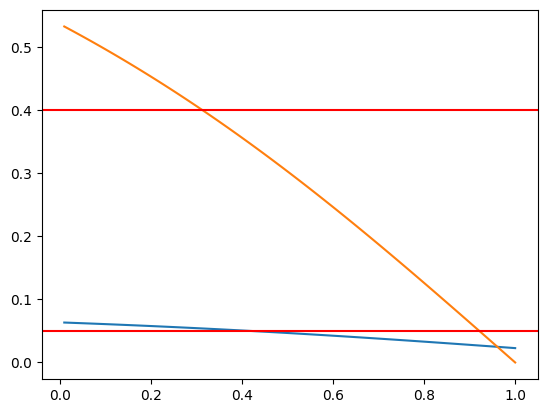

In [381]:
plt.plot(np.linspace(0.01, 1, 100), target_corr)
plt.plot(np.linspace(0.01, 1, 100), pairwise_corr)
# draw horizontal line at 0.5
plt.axhline(y=0.05, color='r', linestyle='-')
plt.axhline(y=0.4, color='r', linestyle='-')
plt.show()

In [382]:
np.linspace(0.01, 1, 100)[np.where((np.array(target_corr) >= 0.05) & (
        np.array(pairwise_corr) <= 0.4))]  # these are the hedge parameter that satisfy the requirement

array([0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41])

In [383]:
np.array(target_corr)[np.where((np.array(target_corr) >= 0.05) & (np.array(
    pairwise_corr) <= 0.4))]  # these are the target corr that satisfy the requirement. we choose the best in these.

array([0.05369357, 0.05333378, 0.05297078, 0.05260458, 0.05223517,
       0.05186257, 0.05148676, 0.05110776, 0.05072556, 0.05034018])

### Demo: Improve performance of past_xs_ret style factors

#### correlation with target

In [384]:
np.corrcoef(new_factors['past_10s_ret'], df_train['target'].fillna(0))[0, 1]  # original factor performance

0.06664332162654614

In [385]:
np.corrcoef(new_factors['past_30s_ret_rank'], df_train['target'].fillna(0))[0, 1]  # original factor performance

0.06302002013895729

#### correlation between factors

In [386]:
np.corrcoef(new_factors['past_10s_ret'], new_factors['past_30s_ret_rank'])[0, 1]  # original factor performance

0.35891290146961646

In [387]:
optimize = [np.corrcoef(np.exp(i * new_factors['past_10s_ret']),
                        df_train['target'].fillna(0) / 10000)[0, 1] for i in np.linspace(1, 100, 100)]

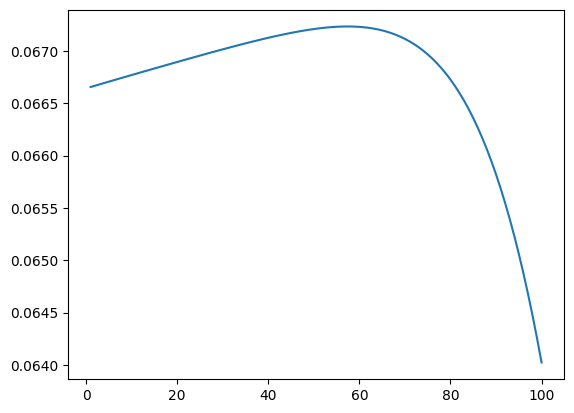

In [388]:
plt.plot(np.linspace(1, 100, 100), optimize)

In [389]:
np.linspace(1, 100, 100)[np.argmax(optimize)]  # the optimal is at 57

57.0

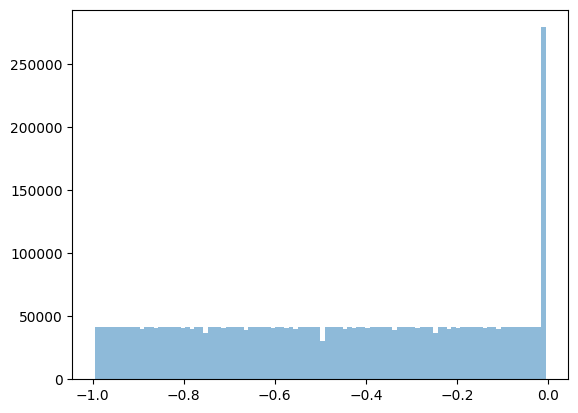

0.06302002013895729


In [390]:
x = new_factors['past_30s_ret_rank']
y = df_train['target'].fillna(0)

plt.hist(x, bins=100, alpha=0.5)
# plt.hist(y, bins=100, alpha=0.5)
plt.show()
print(np.corrcoef(x, y)[0, 1])

### Demo: Improve performance of s1_imbalance

In [391]:
np.corrcoef(new_factors['s1_imbalance'], df_train['target'].fillna(0))[0, 1]  # original factor performance

0.11723116519487425

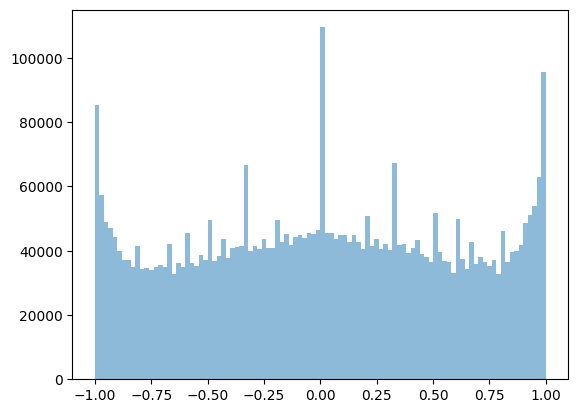

0.11723116519487425


In [392]:
x = new_factors['s1_imbalance']
y = df_train['target'].fillna(0)

plt.hist(x, bins=100, alpha=0.5)
# plt.hist(y, bins=100, alpha=0.5)
plt.show()
print(np.corrcoef(x, y)[0, 1])

If we only look at the sign, we can see it contributes most information (i.e. most of the time we only care about sign)

In [393]:
x = np.sign(new_factors['s1_imbalance'])
y = df_train['target'].fillna(0)

print(np.corrcoef(x, y)[0, 1])

0.09444458059028685


Sign can be viewed as sign*abs**0, so we can optimize the power of abs

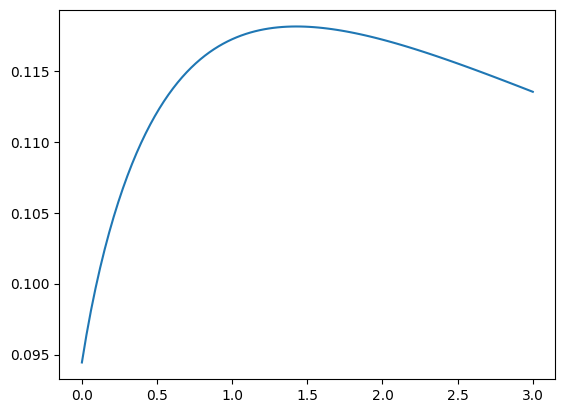

In [394]:
optimize = [np.corrcoef(np.sign(new_factors['s1_imbalance']) * np.abs(new_factors['s1_imbalance']) ** i,
                        df_train['target'].fillna(0))[0, 1] for i in np.linspace(0, 3, 100)]
plt.plot(np.linspace(0, 3, 100), optimize)

In [395]:
np.linspace(0, 3, 100)[np.argmax(optimize)]  # the optimal is at 1.4242424242424243

1.4242424242424243

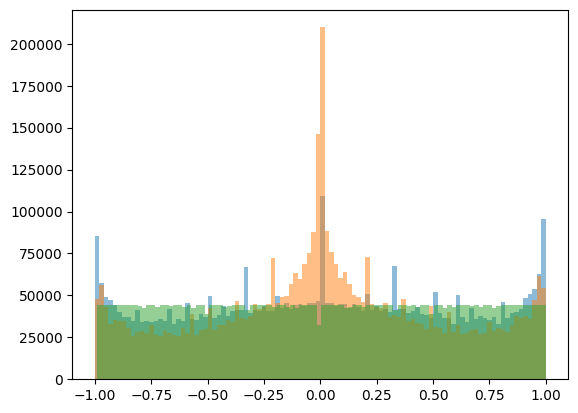

0.11723116519487425
0.11812815373942646
0.11611365395799639


In [396]:
x = new_factors['s1_imbalance']
x_star = new_factors['s1_imbalance_signed_pow_opt']
x_rank = (new_factors['s1_imbalance_rank'] - 0.5) * 2  # centralization

y = df_train['target'].fillna(0)

plt.hist(x, bins=100, alpha=0.5)
plt.hist(x_star, bins=100, alpha=0.5)
plt.hist(x_rank, bins=100, alpha=0.5)
# plt.hist(y, bins=100, alpha=0.5)
plt.show()
print(np.corrcoef(x, y)[0, 1])
print(np.corrcoef(x_star, y)[0, 1])
print(np.corrcoef(x_rank, y)[0, 1])

In [397]:
x = (x - np.mean(x)) / np.std(x)

In [398]:
optimize = [np.corrcoef(np.sign(x) * np.abs(x) ** i,
                        df_train['target'].fillna(0))[0, 1] for i in tqdm(np.linspace(0, 3, 100))]


100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


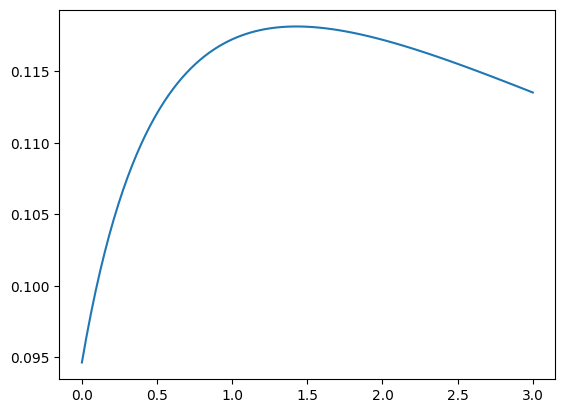

In [399]:
plt.plot(np.linspace(0, 3, 100), optimize)

In [400]:
max(optimize)

0.11812966984378381

In [401]:
np.linspace(0, 3, 100)[np.argmax(optimize)]  # the optimal is at 1.4242424242424243

1.4242424242424243

In [402]:
optimize = [np.corrcoef(stats.t.ppf(stats.rankdata(x_star, method='min') / (len(x_star) + 1), df=i),
                        df_train['target'].fillna(0))[0, 1] for i in tqdm(np.linspace(1, len((x_star)), 10))]


100%|██████████| 10/10 [01:34<00:00,  9.49s/it]


## Factor Backtesting

In [403]:
'''
The factor_backtest is an object that can be used to backtest your factors. It takes three arguments:

    existed_facors: This is the dictionary stored all the passed factors with their names as keys and values as values
    testing_factors: This is the dictionary stored all the factors waited to be tested
    factor_performance: This is the dictionary stored all the factors' performance score (which is the Pearson correlation coefficient
    of factor values vs corresponded target vector)
'''
# We will firstly load the existed factors and the existed factors' performance for you
# This will take 12 seconds, you only need to run this cell once for loading the existed factors and their performance
existed_factors = utils.load_json_factors('./factor_design_ver2_beta/existed_factors.json')
factor_performance = utils.load_json('./factor_design_ver2_beta/factor_performance.json')

In [404]:
demo_backtest = factor_backtest.Factor_Backtest(existed_factors=existed_factors, testing_factors=new_factors,
                                                factor_performance=factor_performance)

In [405]:
demo_backtest.run_testing()  # this will print out the in-sample performance of your factors

Factor s1_imbalance_signed_pow_opt failed in-sample performance check with correlation coefficient 0.11812815373942646
Factor past_10s_ret failed in-sample performance check with correlation coefficient 0.06664332162654614
Factor past_30s_ret_rank failed in-sample performance check with correlation coefficient 0.06302002013895729
Factor stock_20s_ret_deviate_from_index failed in-sample performance check with correlation coefficient 0.08267993902947415
Factor stock_40s_ret_deviate_from_index_rank_hedged_opt failed in-sample performance check with correlation coefficient 0.05405080675974954
Factor stock_40s_ret_deviate_from_index_rank failed in-sample performance check with correlation coefficient 0.06356041069195277
Factor s1_imbalance_rank_signed_pow_opt failed in-sample performance check with correlation coefficient 0.11727393510910067
Factor s1_imbalance failed in-sample performance check with correlation coefficient 0.11723116519487425
Factor s1_imbalance_rank failed in-sample perfo